In [27]:
import pandas as pd
import numpy as np
from pathlib import Path

def tabularize_fuel_oil_no2_pricing(pricing_source_file, output_file, years_to_average, cost_col, output_cost_column):
    """ 
    Average the monthly national fuel oil number 2 pricing 
    """
    fuel_oil_no2_pricing = pd.read_csv(pricing_source_file)
    fuel_oil_no2_pricing.fillna(0)
    fuel_oil_no2_pricing["Year"] = pd.to_datetime(fuel_oil_no2_pricing['Week of']).dt.year
    fuel_oil_no2_pricing["Month"] = pd.to_datetime(fuel_oil_no2_pricing['Week of']).dt.month
    fuel_oil_no2_pricing = fuel_oil_no2_pricing[ fuel_oil_no2_pricing["Year"].isin(years_to_average) ]

    output_fuel_oil_no2_pricing = []
    for month in fuel_oil_no2_pricing["Month"].unique(): 
        data = fuel_oil_no2_pricing[ fuel_oil_no2_pricing["Month"] == month ]
        output_fuel_oil_no2_pricing.append({'Month': month, output_cost_column: data[cost_col].mean()})
    
    output_fuel_oil_no2_pricing = pd.DataFrame(output_fuel_oil_no2_pricing)
    output_fuel_oil_no2_pricing = output_fuel_oil_no2_pricing.sort_values(by=['Month'])
    output_fuel_oil_no2_pricing.to_csv(output_file, index=False)

    return None

    
def tabularize_monthly_state_specific_pricing(input_pricing_file, output_pricing_file, cost_column):
    """ 
    Convert from a table with different columns for each state's price, to rows where each row is a month of a state and its price. 
    """

    pricing = pd.read_csv(input_pricing_file)
    # set the column names for the natural gas 
    national_and_cities_columns = set(pricing.columns) - set("Date")  
    dataframes_list = []
    for column in national_and_cities_columns: 

        if column in us_state_to_abbrev.keys(): state = us_state_to_abbrev.get(column)
        else: state = column 

        temp_df = pd.DataFrame()
        temp_df["Month"] = pricing["Month"].to_list()
        temp_df["State"] = state
        temp_df[cost_column] = pricing[column].to_list()
        dataframes_list.append(temp_df)
        del temp_df

    pricing = pd.concat(dataframes_list)
    pricing.to_csv(output_pricing_file, index=False)
    
    return None


def average_pricing_by_states(pricing_source_file, years_to_average, exclude_cols_from_average):
    """
    Avereage EIA fuel pricing data by month for each state / region
    """

    pricing = pd.read_csv(pricing_source_file)
    pricing.fillna(0)
    pricing = pricing[ pricing["Year"].isin(years_to_average) ]

    cols_to_average = list(set(pricing.columns) - set(exclude_cols_from_average))

    print(cols_to_average)
    
    dataframes_list = []
    for month in pricing["Month"].unique(): 
        data = pricing[ pricing["Month"] == month ]
        data = {col: [data[col].mean()] for col in cols_to_average}   # List comprehension way to build a dictionary of the month's average price for each column to average 
        data = {**{"Month": month}, **data}                         # Add the month to the front of the dictionary
        dataframes_list.append(pd.DataFrame(data))
        del data

    pricing = pd.concat(dataframes_list)
    pricing = pricing.sort_values(by=['Month'])

    return pricing


def linearly_interpolate_pricing(xa, xb, month_col, pricing):
    """ 
    Linearly interpolate missing EIA fuel pricing data 
    """
    pricing_array = pricing.to_numpy()

    m = (pricing_array[pricing_array[:,month_col] == xb] - pricing_array[pricing_array[:,month_col] == xa]) 
    m = m / m[month_col][month_col]

    b = m*(-xa) + pricing_array[pricing_array[:,month_col] == xa]

    for x in range(xa+1, xb):
        y = np.zeros(np.shape(m))
        y = m*x + b 
        pricing_array = np.vstack([pricing_array, y])

    pricing = pd.DataFrame(pricing_array, columns = pricing.columns)
    pricing["Month"] = pricing["Month"].astype(int)
    pricing = pricing.sort_values(by=['Month'])
    return pricing


us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

# Electricity

In [6]:
def average_electricity_pricing(electricity_pricing_file, years_to_average):
    """ 
    Average the price of electricity by month for the given years of electricity pricing data and ignore missing entries. 
    """

    electricity_pricing = pd.read_csv(electricity_pricing_file)
    electricity_pricing["DATE"] = pd.to_datetime(electricity_pricing["DATE"])
    electricity_pricing = electricity_pricing[electricity_pricing["DATE"].dt.year.isin(years_to_average)]    

    electricity_pricing = electricity_pricing[ ~electricity_pricing.iloc[:, 1].isin(['.']) ]                # ignore missing values for averaging 
    electricity_pricing.iloc[:,1] = electricity_pricing.iloc[:,1].astype(float)                             # convert price column to float 

    # month_data
    average_monthly_prices = []
    for month in electricity_pricing["DATE"].dt.month.unique():
        month_data = electricity_pricing[ electricity_pricing["DATE"].dt.month.isin([month]) ]
        average_monthly_prices.append(pd.DataFrame({"Month": [month], "Mean(Price Electricity ($/kWh))": [month_data.iloc[:,1].mean()]}))
    average_monthly_prices = pd.concat(average_monthly_prices)
    
    if len(average_monthly_prices['Month'].unique()) < 12:
        raise RuntimeError(f'Error: {electricity_pricing_file} has missing monthly pricing values')

    return average_monthly_prices


city_electricity_files = {
    'New York': Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Electricity/APUS12A72610_NY.csv"),
    'Los Angeles': Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Electricity/APUS49A72610_Los Angeles.csv"),
    'Detroit': Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Electricity/APUS23B72610_Detroit.csv"),
    'Atlanta': Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Electricity/APUS35C72610_Atlanta_GA.csv"),
    'Dallas': Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Electricity/APUS37A72610_Dallas.csv"),
    }

output_electricity_pricing_file = "/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Electricity/aggregate_data_By_(City,_Month).csv"

years_to_average = range(2019, 2020 +1)

pricing_data = []
for city in city_electricity_files.keys():
    electricity_pricing = average_electricity_pricing(city_electricity_files.get(city), years_to_average)
    electricity_pricing['City'] = city
    pricing_data.append(electricity_pricing)

pricing_data = pd.concat(pricing_data)

pricing_data.to_csv(output_electricity_pricing_file, index=False)


# Natural Gas

In [28]:
nat_gas_pricing_source_file = Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Natural gas/NG_PRI_SUM_A_EPG0_PRS_DMCF_M By (Month).csv")
nat_gas_pricing_output_table_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data", "natural_gas_pricing.csv")

####### (If not done yet) Convert source pricing table (with some minor excel modifications) to table for merging on results ###############
new_cost_column_name = 'Price of Natural Gas Delivered to Residential Consumers (Dollars per Thousand Cubic Feet)'
tabularize_monthly_state_specific_pricing(nat_gas_pricing_source_file, nat_gas_pricing_output_table_file, new_cost_column_name)     



# Fuel Oil

In [ ]:
fuel_oil_no2_pricing_source_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Weekly_U.S._Weekly_No._2_Heating_Oil_Residential_Price_clean header.csv")
fuel_oil_no2_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_No._2_Heating_Oil_Residential_Price.csv") 

###### (If not done yet) Convert source pricing table (with some minor excel modifications) to table for merging on results ###############
years_to_average = range(2019, 2020 +1)
cost_col = "Weekly U.S. Weekly No. 2 Heating Oil Residential Price Dollars per Gallon"
output_cost_column = 'Monthly No. 2 Heating Oil Residential Price Dollars per Gallon'
tabularize_fuel_oil_no2_pricing(fuel_oil_no2_pricing_source_file, fuel_oil_no2_pricing_file, years_to_average, cost_col, output_cost_column)
print("If youve just created the table for the first time, linearly interpolate the missing data")
## If you've just created the table for the first time, linearly interpolate the missing data 
## You might be able to use the function i created for linearly interpolating. For the current data which is just for the whole US (12 data points), I did the interpolationg in excel


# Propane
## First Average the pricing data to the monthly level from weekly level 

In [23]:
pricing_source_file = Path("/Volumes/seas-mtcraig/data_sharing/Energy Burdens Under Climate Change/Energy rates/Propane/weekly_USA/weekly_propane_pricing_USA.csv")
average_propane_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_Propane_Price.csv") 

columns_to_exclude_from_averaging = ["Date",	"Month",	"Year"]

# average_pricing_by_states(columns_to_exclude_from_averaging)
years_to_average = range(2019, 2020 +1)
average_propane_pricing_by_states = average_pricing_by_states(pricing_source_file, years_to_average, columns_to_exclude_from_averaging)
average_propane_pricing_by_states.to_csv(average_propane_pricing_file, index=False)
average_propane_pricing_by_states

['East Coast (PADD 1)', 'Rocky Mountain (PADD 4)', 'Kentucky', 'Mississippi', 'Delaware', 'Pennsylvania', 'South Dakota', 'Montana', 'Midwest (PADD 2)', 'Utah', 'Alabama', 'Lower Atlantic (PADD 1C)', 'Missouri', 'Indiana', 'Georgia', 'Minnesota', 'Maryland', 'Florida', 'Maine', 'Michigan', 'Arkansas', 'Texas', 'North Carolina', 'Colorado', 'New York', 'Virginia', 'Rhode Island', 'Nebraska', 'Kansas', 'Ohio', 'Wisconsin', 'Idaho', 'New Hampshire', 'Iowa', 'North Dakota', 'New Jersey', 'Central Atlantic (PADD 1B)', 'Connecticut', 'Oklahoma', 'Gulf Coast (PADD 3)', 'Tennessee', 'New England (PADD 1A)', 'U.S.', 'Illinois', 'Massachusetts', 'Vermont']


,Month,East Coast (PADD 1),Rocky Mountain (PADD 4),Kentucky,Mississippi,Delaware,Pennsylvania,South Dakota,Montana,Midwest (PADD 2),...,Central Atlantic (PADD 1B),Connecticut,Oklahoma,Gulf Coast (PADD 3),Tennessee,New England (PADD 1A),U.S.,Illinois,Massachusetts,Vermont
0,1,2.910625,1.979625,2.181000,2.420875,2.884875,2.593625,1.469625,1.813375,1.727250,...,2.839250,2.819500,1.827375,2.318625,2.791875,2.958125,2.216000,1.630000,2.934875,3.116875
0,2,2.907750,1.966750,2.182750,2.432375,2.885000,2.588250,1.462500,1.802750,1.714000,...,2.841375,2.786500,1.818125,2.319875,2.791750,2.948625,2.207125,1.587250,2.931750,3.105500
0,3,2.850778,1.906556,2.151556,2.414778,2.847444,2.530222,1.401111,1.785778,1.649556,...,2.790444,2.725556,1.774333,2.269333,2.684000,2.901667,2.141111,1.535111,2.905444,3.036778
0,10,2.526125,1.528125,1.975500,2.221500,2.552250,2.151750,1.254500,1.408500,1.398500,...,2.383625,2.661875,1.529875,2.033125,2.307750,2.669875,1.813875,1.320375,2.772750,2.643000
0,11,2.551556,1.621333,1.965556,2.260111,2.551778,2.163889,1.350111,1.517111,1.515111,...,2.403000,2.692444,1.610556,2.087333,2.361889,2.691889,1.891778,1.494778,2.752222,2.696000
0,12,2.632444,1.718444,1.990000,2.302222,2.600000,2.249778,1.414111,1.594111,1.607000,...,2.488222,2.772778,1.672111,2.154000,2.452889,2.778000,1.977889,1.600667,2.796889,2.838333


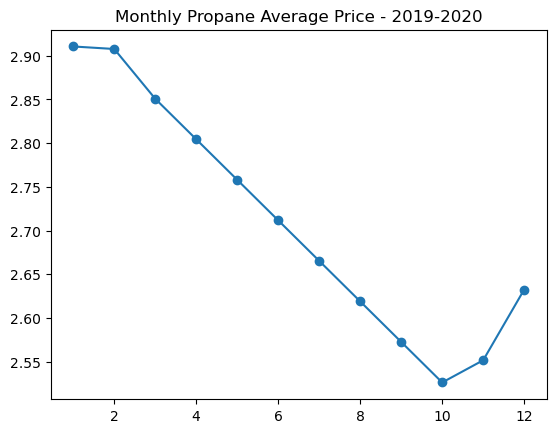

In [24]:
average_propane_pricing_by_states = pd.read_csv(average_propane_pricing_file)
interpolated_propane_pricing_file = Path("/Users/camilotoruno/Documents/local_research_data/pricing_data/Monthly_Propane_Price_Interpolated.csv") 

# xa and xb chosen as Months on either side of the missing months section
xa = 3
xb = 10    
month_col = 0

interpolated_average_propane_pricing_by_states = linearly_interpolate_pricing(xa, xb, month_col, average_propane_pricing_by_states)

import matplotlib.pyplot as plt
plt.plot(interpolated_average_propane_pricing_by_states.iloc[:,0], interpolated_average_propane_pricing_by_states.iloc[:,1], marker='o')
plt.title(f"Monthly Propane Average Price - {years_to_average[0]}-{years_to_average[-1]}")

interpolated_average_propane_pricing_by_states.to_csv(interpolated_propane_pricing_file, index=False)

### Now tabularize the data 
Convert from a table with different columns for each state's price, to rows where each row is a month of a state and its price. 

In [26]:
new_cost_column_name = 'Monthly U.S. Propane Residential Price (Dollars per Gallon)'
tabularize_monthly_state_specific_pricing(interpolated_propane_pricing_file, interpolated_propane_pricing_file, new_cost_column_name)

# interpolated_propane_pricing = pd.read_csv(interpolated_propane_pricing_file)
# interpolated_propane_pricing

,Month,State,Monthly U.S. Propane Residential Price (Dollars per Gallon)
0,1,East Coast (PADD 1),2.910625
1,2,East Coast (PADD 1),2.907750
2,3,East Coast (PADD 1),2.850778
3,4,East Coast (PADD 1),2.804399
4,5,East Coast (PADD 1),2.758020
...,...,...,...
559,8,VT,2.755508
560,9,VT,2.699254
561,10,VT,2.643000
562,11,VT,2.696000
